## Modeling and Inferential Analysis

In this section, we're going to look at the predictive power of certain match statistics by fitting a logistic regression base model, as well as RandomForests, to examine which ones are the most important.

This is different from our statistical tests previously that are looking at a hypothesis to decide whetherthe result is likely to have happened by chance.  Rather, this analysis helps us decide whether or not it could be beneficial to increase model complexity by using a feature due to its predictive power. (See https://statisticalhorizons.com/wp-content/uploads/GOFForLogisticRegression-Paper.pdf.)

Adding features to a model, ergo, increasing model complexity, is always a trade-off as increasing model complexity could lead to better results, but makes a model prone to overfitting (a statistical model that contains more parameters than can be justified by the data).

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

# Set standard figure size for plots
mlp.rcParams['figure.figsize'] = (120,60)

# Set Seaborn Styles
sns.set()

# Set Color Palette that can be used for plotting
colorsP = ['#D28DDC','#CA7AD6','#C366D0','#BB53CA','#B340C3','#A337B2','#A437B3','#92319F','#802B8C','#6E2578']
colorsP = colorsP[::-1]

In [2]:
# Read in Training and Test Data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = train.drop(['Unnamed: 0'], axis = 1)
test = test.drop(['Unnamed: 0'], axis = 1)

In [3]:
# Store Feature Columns and Target Variable Column
features = ['rank_dif','aces','double_faults','first_serves_in', 'first_serve_points_won','second_serve_points_won',
            'break_points_saved','service_points_won','first_serve_return_won','second_serve_return_won',
            'break_points_converted','service_games_played','return_games_played','return_points_won',
            'total_points_won','games_won','ace_pct','df_pct','srv_pts_pct','rtn_pts_pct','brk_pts_pct','points_won_pct']
predictor = ['win']

In [4]:
# Store Features and Target Columns in Variable
features_with_target = ['rank_dif','aces','double_faults','first_serves_in',
                        'first_serve_points_won','second_serve_points_won','break_points_saved','service_points_won',
                        'first_serve_return_won','second_serve_return_won','break_points_converted','service_games_played',
                        'return_games_played','return_points_won','total_points_won','games_won',
                        'ace_pct','df_pct','srv_pts_pct','rtn_pts_pct','brk_pts_pct','points_won_pct','win']

In [5]:
from sklearn.model_selection import train_test_split

# Split Training Data in Holdout Set and Training and Test Data sets
Xy_train = train.loc[:,features + predictor]

Xy_train.head()
X = Xy_train.drop('win',axis=1)
y = Xy_train['win']

X_tune, X_hold, y_tune, y_hold = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.2, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler

def scale_data(X_train,X_test):
    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, scaler

# Get Scaled Training and Test Features
X_train, X_test, scaler = scale_data(X_train, X_test)

C:\Users\ironm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ironm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ironm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ironm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ironm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic

LR Scores:  [0.99443086 0.99340021 0.99331586 0.99437721 0.99277909]
Mean ROC AUC Score: 0.9936606477195846
LR Score Range: 0.0017


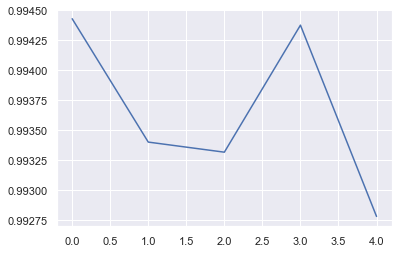

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

def run_lr(X_train,y_train):
    """
    Run a Logistic Recression of Features and Target Variable. We're using ROC AUC Score with Cross Validation
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    lr = LogisticRegression(solver='lbfgs')
    
    lr_scores = cross_val_score(lr,
                                X_train,
                                y_train,
                                cv=5,
                                scoring='roc_auc')
    
    print('LR Scores: ', lr_scores)
    print('Mean ROC AUC Score: {}'.format(lr_scores.mean()))
    print('LR Score Range: {}'.format(round(lr_scores.max() - lr_scores.min(),4)))
    _ = plt.plot(np.arange(len(lr_scores)),lr_scores)
    return lr

lr = run_lr(X_train,y_train)

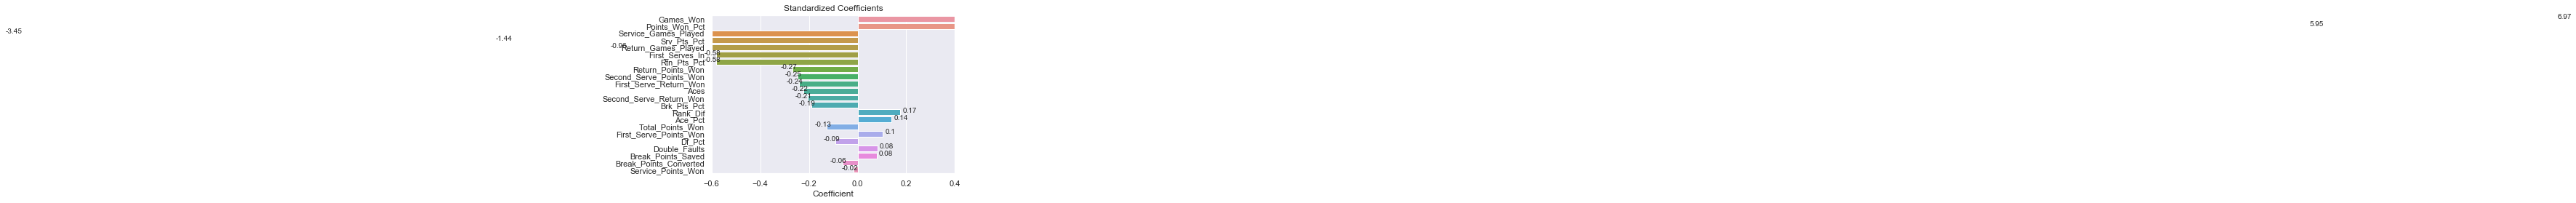

In [10]:
def plot_coef(X,y,features):
    """
    Plot the Beta values of a Logistic Regression based on the Features and Target Variable provided.
    """
    lr = LogisticRegression(solver='lbfgs')
    std_scaler = StandardScaler()
    X_train_std = std_scaler.fit_transform(X_train)
    lr.fit(X_train,y_train)
    std_coef = lr.coef_.reshape(-1,1).tolist()
    feature_names = [feature.title() for feature in features]
    coef_df = pd.DataFrame(std_coef,index=feature_names,columns=['coef'])
    coef_df['abs'] = coef_df['coef'].abs()
    coef_df = coef_df.sort_values(by='abs',ascending=False).drop('abs',axis=1)
    ax = sns.barplot(coef_df['coef'],coef_df.index)
    for i, row in enumerate(coef_df.iterrows()):
        row_values = row[1]
        if row_values.coef < 0:
            ax.text(row_values.coef - 0.05,i,round(row_values.coef,2))
        else:
            ax.text(row_values.coef + 0.01,i,round(row_values.coef,2))
    _ = plt.xlabel('Coefficient')
    _ = plt.title('Standardized Coefficients')
    _ = plt.xlim(-0.6,0.4)

plot_coef(X_train,y_train,features)

In [12]:
# find correlations to target
corr_matrix = X_tune.corr().abs()

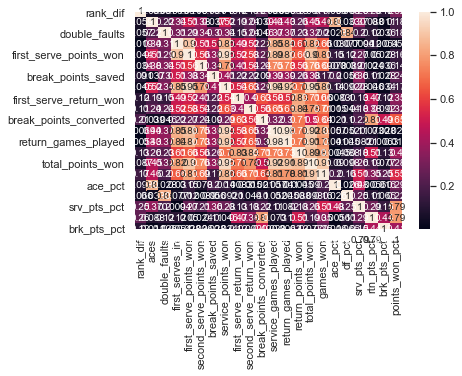

In [13]:
# Plot correlations for Tuning variables
sns.heatmap(corr_matrix,annot=True)
plt.show;

In [15]:
corr_matrix.points_won_pct[:-1]

rank_dif                   0.316071
aces                       0.182644
double_faults              0.180783
first_serves_in            0.052438
first_serve_points_won     0.159084
second_serve_points_won    0.138783
break_points_saved         0.240088
service_points_won         0.169661
first_serve_return_won     0.351316
second_serve_return_won    0.318881
break_points_converted     0.646714
service_games_played       0.028152
return_games_played        0.017337
return_points_won          0.399581
total_points_won           0.284023
games_won                  0.548098
ace_pct                    0.291850
df_pct                     0.223046
srv_pts_pct                0.792689
rtn_pts_pct                0.794909
brk_pts_pct                0.408618
Name: points_won_pct, dtype: float64

In [16]:
from sklearn.linear_model import LinearRegression

In [18]:
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
print(lm.intercept_)

0.4989139589520813


In [24]:
# coeff=pd.DataFrame(lm.coef_,X_train.features,columns=['Coefficient'])

AttributeError: 'numpy.ndarray' object has no attribute 'features'

In [25]:
predictions= lm.predict(X_test)

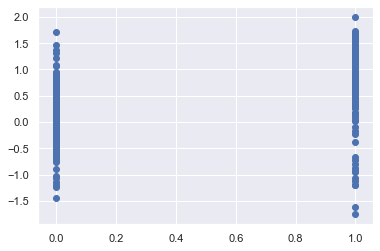

In [26]:
plt.scatter(y_test,predictions)

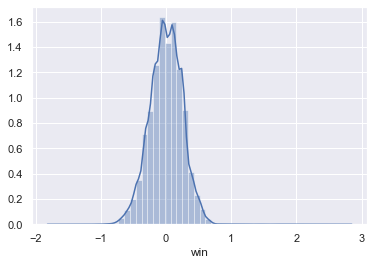

In [27]:
sns.distplot(y_test-predictions)

In [28]:
from sklearn import metrics

In [30]:
print('Mean_Absolute_Error : ' , metrics.mean_absolute_error(y_test,predictions))
print('Mean_Squared_Error : ' , metrics.mean_squared_error(y_test,predictions) )
print('Root_Mean_Squared_Error : ', np.sqrt(metrics.mean_squared_error(y_test,predictions)))

Mean_Absolute_Error :  0.19775145522871979
Mean_Squared_Error :  0.06327517675085563
Root_Mean_Squared_Error :  0.2515455758920352


In [31]:
predictions

array([ 0.18561498,  0.91380038,  0.05081143, ...,  0.86030345,
       -0.04116065,  0.88092597])